In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset, load_from_disk, Dataset
import torch
import re, math

## Dataset Loading

In [3]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("sled-umich/Action-Effect", trust_remote_code=True)

categories = [
    row['verb noun'] for row in dataset['ActionEffect']
]

dataset

DatasetDict({
    ActionEffect: Dataset({
        features: ['verb noun', 'effect_sentence_list', 'effect_phrases_list', 'positive_image_list', 'negative_image_list'],
        num_rows: 140
    })
})

bind hair


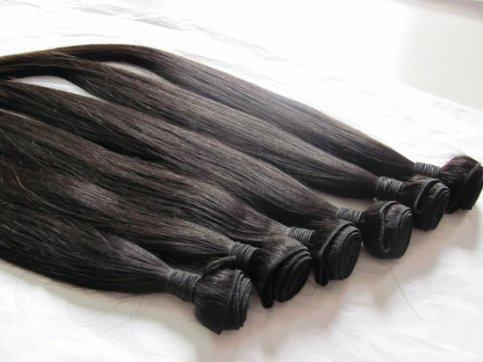

In [7]:
i = 6

print(dataset['ActionEffect'][i]['verb noun'])
dataset['ActionEffect'][i]['positive_image_list'][0]

## Compressing Captions

In [ ]:
import pickle
with open('blip-large-captions.pt', 'rb') as f:
    output = pickle.load(f)

In [ ]:
import importlib #import the module here, so that it can be reloaded.
import convert_to_category
importlib.reload(convert_to_category)

<module 'convert_to_category' from '/home/elijfox/nlp/FinalProject/convert_to_category.py'>

In [1]:
from convert_to_category import convert_to_category

In [ ]:
i = 30

print(output['captions'][i])
pred_idxs, pred_cats, pred_vals = convert_to_category([output['captions'][i]], topk=5)
print(pred_idxs)
print(pred_cats)
print(output['verb-noun'][i])

there are some white flowers in a glass jar on a tray
tensor([[  1,  44,  16,  71, 121]])
[['arrange flowers', 'crack glass', 'break glass', 'label bottle', 'stain paper']]
arrange flowers


## Dataset Flattening

In [4]:
from datasets import Dataset

In [5]:
import pickle
with open('blip-large-captions.pt', 'rb') as f:
    output = pickle.load(f)

In [5]:
from datasets import load_from_disk
flat_dataset = load_from_disk('./flat_dataset')

In [2]:
flat_dataset

DatasetDict({
    train: Dataset({
        features: ['images', 'action'],
        num_rows: 475
    })
    test: Dataset({
        features: ['images', 'action'],
        num_rows: 1573
    })
})

In [ ]:
import math
from datasets import load_from_disk, Dataset
import pickle

flat_dataset = load_from_disk('./datasets/flat_dataset')

with open('blip-large-captions.pt', 'rb') as f:
    captions_dataset = Dataset.from_dict(pickle.load(f))

train_split = 0.2

train_captions = []
test_captions = []

i = 0
for category in dataset['ActionEffect']:
    n = len(category['positive_image_list'])
    train_n = math.ceil(n*train_split)
    test_n = n - train_n
    
    train_captions.extend(captions_dataset['captions'][i:i+train_n])
    test_captions.extend(captions_dataset['captions'][i+train_n:i+n])
    
    i += n

flat_dataset['train'] = flat_dataset['train'].add_column('captions', train_captions)
flat_dataset['test'] = flat_dataset['test'].add_column('captions', test_captions)

flat_dataset.save_to_disk('./datasets/flat_dataset_captions')

In [ ]:
flat_dataset_captions = load_from_disk('./datasets/flat_dataset_captions')

In [42]:
flat_dataset_captions

DatasetDict({
    train: Dataset({
        features: ['images', 'action', 'caption'],
        num_rows: 475
    })
    test: Dataset({
        features: ['images', 'action', 'caption'],
        num_rows: 1573
    })
})

bend tree
a lone tree in a field with a cloudy sky


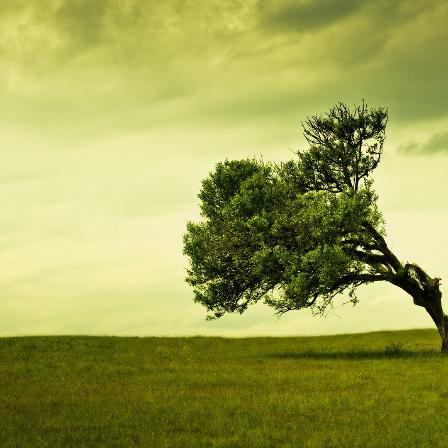

In [11]:
i = 19

print(flat_dataset_captions['train']['action'][i])
print(flat_dataset_captions['train']['captions'][i])
flat_dataset_captions['train']['images'][i]

## Top-K Accuracy from Predictions

In [5]:
def gt_category_to_idx(gt):
    return torch.Tensor([categories.index(e) for e in gt]).long()

In [6]:
from eval_sentence_sim import *

### Captions Only

In [44]:
pred_idxs_cap, pred_cats_cap = get_predictions(flat_dataset_captions['test'], key='caption')

In [51]:
gt_idxs_cap = gt_category_to_idx(flat_dataset_captions['test']['action'])

In [52]:
for topk in [1, 5, 20]:
    acc = get_topk_acc(pred_idxs_cap, gt_idxs_cap, topk=topk)
    print(f'Top-{topk} acc: {acc}')

Top-1 acc: 0.4227590560913086
Top-5 acc: 0.795931339263916
Top-20 acc: 0.9567704796791077


In [53]:
gt_idxs_cap

tensor([  0,   0,   0,  ..., 139, 139, 139])

### Compressed Captions Finetuned

In [ ]:
compressed_captions_ft = torch.load('compressed_captions.torch', weights_only=True)
compressed_captions_ft = Dataset.from_dict(compressed_captions_ft)

In [ ]:
compressed_captions_ft

Dataset({
    features: ['outputs', 'pred', 'gt'],
    num_rows: 1573
})

In [ ]:
pred_idxs_ft, pred_cats_ft = get_predictions(compressed_captions_ft, key='pred')

In [ ]:
gt_idxs_ft = gt_category_to_idx(compressed_captions_ft['gt'])

In [ ]:
print('Identical Accuracy:', get_identical_acc(compressed_captions_ft['pred'], compressed_captions_ft['gt']))

for topk in [1, 5, 20]:
    acc = get_topk_acc(pred_idxs_ft, gt_idxs_ft, topk=topk)
    print(f'Top-{topk} acc: {acc}')

Identical Accuracy: 0.4628099173553719
Top-1 acc: 0.48378893733024597
Top-5 acc: 0.8169103860855103
Top-20 acc: 0.9427844882011414


### Compressed Captions Zero-Shot

In [ ]:
compressed_captions_zsh = torch.load('compressed_captions_zsh.torch', weights_only=True)
compressed_captions_zsh = Dataset.from_dict(compressed_captions_zsh)

In [37]:
compressed_captions_zsh

Dataset({
    features: ['outputs', 'pred', 'gt'],
    num_rows: 1573
})

In [ ]:
zsh_actions = []

for predicted_output in compressed_captions_zsh['outputs']:
    predicted_answer = re.search(r'### Answer:.*?([a-z]+ [a-z]+)', predicted_output)
    if predicted_answer != None:
        predicted_answer = predicted_answer.groups()[0].strip()
    else:
        predicted_answer = ''
    
    zsh_actions.append(predicted_answer)

zsh_actions

In [38]:
pred_idxs_zsh, pred_cats_zsh = get_predictions(compressed_captions_zsh, key='pred')

In [39]:
gt_idxs_zsh = gt_category_to_idx(compressed_captions_zsh['gt'])

In [40]:
print('Identical Accuracy:', get_identical_acc(compressed_captions_zsh['pred'], compressed_captions_zsh['gt']))

for topk in [1, 5, 20]:
    acc = get_topk_acc(pred_idxs_zsh, gt_idxs_zsh, topk=topk)
    print(f'Top-{topk} acc: {acc}')

Identical Accuracy: 0.11506675143038779
Top-1 acc: 0.26446279883384705
Top-5 acc: 0.5193896889686584
Top-20 acc: 0.6694214940071106


## Probability Distribution

a close up of a stack of books on a white surface
pile books
pile books


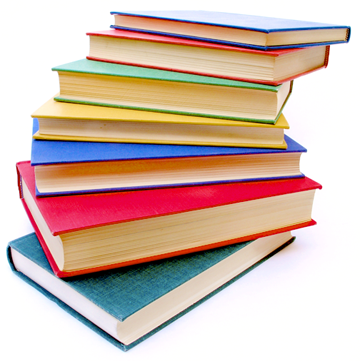

In [15]:
# i = 1050
i = 1070

print(flat_dataset_captions['test']['caption'][i])
print(compressed_captions['pred'][i])
print(compressed_captions['gt'][i])

flat_dataset_captions['test']['images'][i]

In [28]:
batch_idxs, batch_cats, batch_vals = convert_to_category(['pile books'], topk=5)

for i in range(len(batch_cats[0])):
    print(f'{batch_cats[0][i]}: {batch_vals[0][i]:.3f}')

pile books: 1.000
pile boxes: 0.716
pile wood: 0.691
carry book: 0.606
wrap book: 0.503
